Tutorial 1
Practical Course: Learning For Self-Driving Cars and Intelligent Systems
Summer Semester 2021
Technical University of Munich
https://vision.in.tum.de/teaching/ss2021/intellisys_ss2021

In [5]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from skimage import io
import os
import json
import pdb
import copy
from scipy import ndimage
import cv2

In [7]:
FOLDER = "/usr/prakt/s0013/week1/dataset/"
cam1 = 2
frame1 = 215 
cam2 = 1
frame2 = 215

In [8]:
frame1 = format(frame1, '05d')
frame2 = format(frame2, '05d')

In [9]:
rgb_file1   = os.path.join(FOLDER, "CameraRGB{}/image_{}.png".format(cam1, frame1))
rgb_file2   = os.path.join(FOLDER, "CameraRGB{}/image_{}.png".format(cam2, frame2))
depth_file1 = os.path.join(FOLDER, "CameraDepth{}/image_{}.png".format(cam1, frame1))
depth_file2 = os.path.join(FOLDER, "CameraDepth{}/image_{}.png".format(cam2, frame2))
intrinsics_file = os.path.join(FOLDER,"camera_intrinsic.json")


In [ ]:
rgb_file1

Error: Session cannot generate requests

In [12]:
with open(intrinsics_file) as f:
    K = json.load(f)
K = np.array(K)

In [13]:
def read_rgb(rgb_file):
    rgb = io.imread(rgb_file)
    plt.imshow(rgb)
    plt.title(rgb_file)
    plt.show()
    return rgb

def read_depth(depth_file):
    depth = io.imread(depth_file)
    # Reference: https://carla.readthedocs.io/en/latest/ref_sensors/#depth-camera
    depth = depth[:, :, 0] * 1.0 + depth[:, :, 1] * 256.0 + depth[:, :, 2] * (256.0 * 256)
    depth = depth * (1/ (256 * 256 * 256 - 1))
    plt.imshow(depth)
    plt.title(depth_file)
    plt.show()
    return depth

def point_cloud_to_image(points,color ,K,transformation = None):
    points = np.transpose(points, (1,0))
    if transformation is not None:
        tmp = np.ones((4,points.shape[1]))
        tmp[:3,:] = points
        tmp = transformation @ tmp
    else:
        tmp = points
    tmp = K @ tmp
    tmp1 = tmp/tmp[2,:]
    # Note that multiple points might be mapped to the same pixel
    # The one with the lowest depth value should be assigned to that pixel
    # However, note this has not been implemented here
    # One may want to implement this
    u_cord = np.clip(np.round(tmp1[0,:]),0,511).astype(np.int)
    v_cord = np.clip(np.round(tmp1[1,:]),0,511).astype(np.int)
    if color is not None:
        imtmp = np.zeros((512,512,3)).astype(np.uint8)
        imtmp[u_cord, v_cord,:]= (color * 255).astype(np.uint8)
        
    else:
        imtmp = np.zeros((512,512)).astype(np.uint8)
        imtmp[u_cord, v_cord] = tmp[2,:]
        
    imtmp = cv2.flip(ndimage.rotate(imtmp, 90),1) # For some reason the axis were flipped
                                                  # therefore have been fixed here
        
    plt.imshow(imtmp)
    plt.show()
        
    return imtmp
    

def depth_to_local_point_cloud(depth, color=None, k = np.eye(3),max_depth=1.0):
    """
    Convert an image containing CARLA encoded depth-map to a 2D array containing
    the 3D position (relative to the camera) of each pixel and its corresponding
    RGB color of an array.
    "max_depth" is used to omit the points that are far enough.
    """
    "Reference: https://github.com/carla-simulator/driving-benchmarks/blob/master/version084/carla/image_converter.py"
    far = 1000.0  # max depth in meters.
    normalized_depth = depth# depth_to_array(image)
    height, width = depth.shape

    # 2d pixel coordinates
    pixel_length = width * height
    u_coord = repmat(np.r_[width-1:-1:-1],
                     height, 1).reshape(pixel_length)
    v_coord = repmat(np.c_[height-1:-1:-1],
                     1, width).reshape(pixel_length)
    if color is not None:
        color = color.reshape(pixel_length, 3)
    normalized_depth = np.reshape(normalized_depth, pixel_length)

    # Search for pixels where the depth is greater than max_depth to
    # delete them
    max_depth_indexes = np.where(normalized_depth > max_depth)
    normalized_depth = np.delete(normalized_depth, max_depth_indexes)
    u_coord = np.delete(u_coord, max_depth_indexes)
    v_coord = np.delete(v_coord, max_depth_indexes)
    if color is not None:
        color = np.delete(color, max_depth_indexes, axis=0)

    # pd2 = [u,v,1]
    p2d = np.array([u_coord, v_coord, np.ones_like(u_coord)])

    # P = [X,Y,Z]
    p3d = np.dot(np.linalg.inv(k), p2d)
    p3d *= normalized_depth * far
    
    p3d = np.transpose(p3d, (1,0))

    if color is not None:
        return p3d, color / 255.0
    else:
        return p3d, None

In [ ]:
rgb1 = read_rgb(rgb_file1)
rgb2 = read_rgb(rgb_file2)
depth1 = read_depth(depth_file1)
depth2 = read_depth(depth_file2)

Error: Session cannot generate requests

In [ ]:
pc1, color1 = depth_to_local_point_cloud(depth1, color=rgb1, k = K,max_depth=0.05)
pc2, color2 = depth_to_local_point_cloud(depth2, color=rgb2, k = K,max_depth=0.05)
print(pc1)
rgb1_projected = point_cloud_to_image(pc1,color1, K).astype(np.int16)
plt.imshow(np.abs(rgb1_projected - rgb1))

Error: Session cannot generate requests

In [ ]:
transformation = np.eye(4)[:3,:]
print(transformation)
transformation[0,3] = +1.0

projected_image = point_cloud_to_image(pc1,color1, K, transformation = transformation).astype(np.int16)
plt.imshow(np.abs(rgb2-projected_image))

Error: Session cannot generate requests

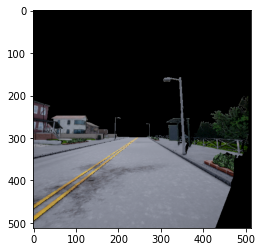

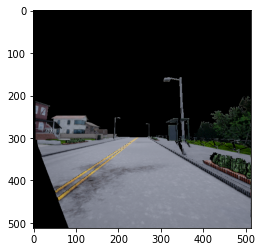

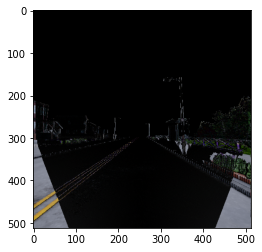

In [17]:
transformation = np.eye(4)[:3,:]
transformation[0,3] = +0.5

projected_imagefrom1 = point_cloud_to_image(pc1,color1, K, transformation = transformation).astype(np.int16)

transformation = np.eye(4)[:3,:]
transformation[0,3] = -0.5

projected_imagefrom2 = point_cloud_to_image(pc2,color2, K, transformation = transformation).astype(np.int16)
plt.imshow(np.abs(projected_imagefrom2 - projected_imagefrom1))


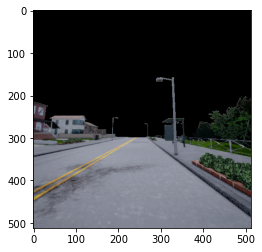

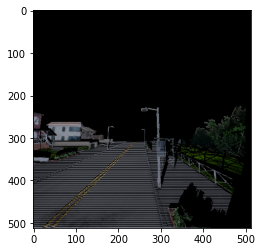

In [18]:
_ = point_cloud_to_image(pc2,color2, K)

transformation = np.eye(4)[:3,:]
transformation[0,3] = +1.0
transformation[1,3] = -2.0


_ = point_cloud_to_image(pc2,color2, K, transformation = transformation)

In [13]:
# %matplotlib inline
%matplotlib qt
for i in range(20):
    transformation = np.eye(4)[:3,:]
    transformation[0,3] = -0.05*i
    point_cloud_to_image(pc2,color2, K, transformation = transformation)
    plt.pause(0.1)

In [14]:
# %matplotlib inline
%matplotlib qt
for i in range(20):
    transformation = np.eye(4)[:3,:]
    transformation[0,3] = 0.05*i
    point_cloud_to_image(pc2,None, K, transformation = transformation)
    plt.pause(0.1)

# Below are some suggested depth transfomrations as alluded to in Slide 29

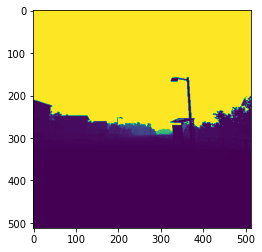

In [15]:
%matplotlib inline
depth = depth1 * 1000 # Depth in CARLA are normalized to between 0 and 1.0, where 1 represents 1000m
plt.imshow(depth)

1.4966727195187044 50.0


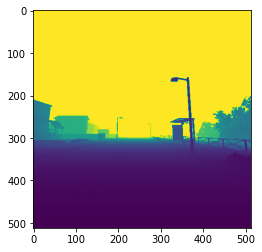

In [16]:
# Clip depth values below 1m and above 50m
min_depth = 1.0 
max_depth = 50  
clipped_depth  = np.clip(depth, min_depth , max_depth) 
plt.imshow(clipped_depth)
print(clipped_depth.min(), clipped_depth.max())

0.40324445729972686 3.912023005428146


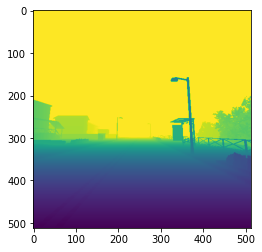

In [17]:
# Display the log of the clipped depth
logarithmic_depth  = np.log(clipped_depth)
plt.imshow(logarithmic_depth )
print(logarithmic_depth.min(), logarithmic_depth.max())

0.02 0.6681487455197133


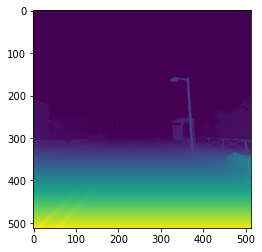

In [18]:
# display the inverse of the clipped depth
inverse_depth = 1 / clipped_depth
plt.imshow(inverse_depth)
print(inverse_depth.min(), inverse_depth.max())

0.25562221863533147 2.479885295129331


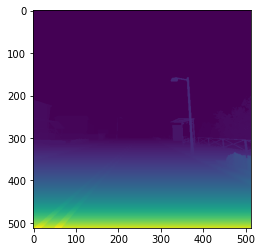

In [19]:
# Display the inverse of the log of the clipped depth
inv_log_depth = 1 / logarithmic_depth
plt.imshow(inv_log_depth)
print(inv_log_depth.min(), inv_log_depth.max())